# **GWU Doctoral Cyber Security Alaytics: Praxis Research**

# **A Holistic Approach to Enable Dynamic Policy Management for Zero Trust Architecture**

## Jody Spearing

## July 2025

## V3.5

## --------------------------------------------------------------------------------
##  **SOFM Clustering Overview**
### **Section 1:** Library and Data load: original dataframe = df_0
### **Section 2:** Basic Data Exploration on df_0
### **Section 3:** Preprocessing on df_1
### **Section 4:** Feature Selection
### **Section 5:** Functions
### **Section 6:** SOFM Model
### **Section 7:** Calculate Metrics
### **Section 8:** Display Visualizations
--------------------------------------------------------------------------------


# **Section 1: Library and Data load: original dataframe = df_0**

In [ ]:
######################################################################################################################
# Install Necessary Libraries
######################################################################################################################

!pip install minisom
#!apt-get -y install cuda
#!pip install pycuda # Moved before cuda-python
#!pip install cuda-python
#!pip install cudf-cu11
#!pip install --upgrade rmm

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=dddd5250acb974887bfafd3f9b189e1a917674df44d2f4a5e12eba3fde30100f
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [ ]:
# check CUDA version
!nvidia-smi

#Use cudf.pandas as a magic
#%load_ext cudf.pandas

Wed Apr 23 22:19:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
######################################################################################################################
## Import Python libraries
######################################################################################################################

import pandas as pd
import numpy as np
import time
import os
from google.colab import drive
import logging
#import cudf
import cupy as cp
from math import comb
from psutil import virtual_memory
import tensorflow as tf
import torch

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture
from minisom import MiniSom

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

# Preprocessing Libraries
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold

#Clustering Metrics Libraries
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
######################################################################################################################
# Get GPU info
# Run the 'nvidia-smi' command to get GPU status information.
# The '!' syntax is used in environments like Jupyter Notebooks to execute shell commands.
# Join the output list into a single string separated by newline characters.
# Check if the word 'failed' appears in the output, which may indicate no GPU is connected or accessible.
# Inform the user that no GPU is connected.
# Otherwise, print the GPU information retrieved.
######################################################################################################################

# Colab GPU Configuration
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 23 22:19:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
######################################################################################################################
# Get memory info
# Import the virtual_memory function from the psutil module
# psutil is a cross-platform library for retrieving system information like CPU, memory, disks, etc.
# Get the total available RAM in bytes and convert it to gigabytes by dividing by 1e9 (1,000,000,000)
# Print the amount of available RAM with one decimal place

# Check if the available RAM is less than 20 GB
# If so, inform the user that this is not a high-RAM runtime
# Otherwise, inform the user they are using a high-RAM runtime
######################################################################################################################

# Memory Configurtion
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
######################################################################################################################
# Environment Setup
# Set Logging
# Set Utilization to 90-100% during training
######################################################################################################################

logging.basicConfig(level=logging.INFO)
!nvidia-smi

Wed Apr 23 22:19:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# **Section 1: Load Data: Original Dataframe = df_0**

In [ ]:
######################################################################################################################
# get / set working directory
# List Contents of working directory
######################################################################################################################

drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive"

Mounted at /content/gdrive
'Colab Notebooks'  'GWU Praxis Notebook HTML'   IMG_0006.jpg
 GWU		    IMG_0001.jpg	       'Jody Spearing Statement.gdoc'


In [ ]:
######################################################################################################################
# Load Data file into dataframe 'df_0' denoting original
# Define the path to the Google Drive directory where the dataset is stored
# Define the name of the dataset file
# Combine the path and filename into a full path to the data file
# Optional: Limit the number of rows read for testing large files (commented out)
# nRowsRead = 1000000  # used for testing
# Read the CSV file into a pandas DataFrame
# Optionally, you could use nrows=nRowsRead for testing large datasets
# Print the first few rows of the DataFrame to verify that the file was read correctly
# Handle case where the file path is incorrect or file is missing
# Handle case where the CSV file has formatting issues and can't be parsed
# Catch any other unexpected exceptions and print the error message
######################################################################################################################

drive_path = '/content/gdrive/My Drive/GWU/Praxis/data/'
data = 'Dataset-Unicauca-Version2-87Atts 2.csv'
data_file = drive_path + data
nRowsRead = 1_500_000


try:
  #df_0 = pd.read_csv(data_file, nrows = nRowsRead)
  df = pd.read_csv(data_file)
  print(df.head()) # Print the first few rows to verify

  # Sample 1MM rows
  data_sampled = df.sample(n=nRowsRead, random_state=42)

except FileNotFoundError:
  print(f"Error: File not found at {data_file}")
except pd.errors.ParserError:
    print(f"Error: Unable to parse the file at {data_file}. Check file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

df_0 = data_sampled.copy()

                                 Flow.ID      Source.IP  Source.Port  \
0    172.19.1.46-10.200.7.7-52422-3128-6    172.19.1.46        52422   
1    172.19.1.46-10.200.7.7-52422-3128-6     10.200.7.7         3128   
2   10.200.7.217-50.31.185.39-38848-80-6   50.31.185.39           80   
3   10.200.7.217-50.31.185.39-38848-80-6   50.31.185.39           80   
4  192.168.72.43-10.200.7.7-55961-3128-6  192.168.72.43        55961   

  Destination.IP  Destination.Port  Protocol           Timestamp  \
0     10.200.7.7              3128         6  26/04/201711:11:17   
1    172.19.1.46             52422         6  26/04/201711:11:17   
2   10.200.7.217             38848         6  26/04/201711:11:17   
3   10.200.7.217             38848         6  26/04/201711:11:17   
4     10.200.7.7              3128         6  26/04/201711:11:17   

   Flow.Duration  Total.Fwd.Packets  Total.Backward.Packets  ...  Active.Std  \
0          45523                 22                      55  ...         0.0  

# **Section 2: Basic Data Exploration on df_0**

In [ ]:
######################################################################################################################
# Basic Data Exploration
# Print the shape of the dataset (rows, columns)
# Print concise summary of the DataFrame: column names, non-null counts, and data types
# Print descriptive statistics for numeric columns (count, mean, std, min, etc.)
# Print the list of column names
# Print the first 5 rows of the dataset
# Print the last 5 rows of the dataset
# Print the count of missing (null) values for each column
# Print the number of duplicated rows in the dataset
# Print the number of unique values for each column
# Print the data type of each column
# Print the memory usage of each column
######################################################################################################################

print('------------------------------------------------------------')
print('DATASET SHAPE')
print('------------------------------------------------------------')
print(df_0.shape)
print('------------------------------------------------------------')
print('DATASET INFO')
print('------------------------------------------------------------')
print(df_0.info())
print('------------------------------------------------------------')
print('DATASET DESCRIBE')
print('------------------------------------------------------------')
print(df_0.describe())
print('------------------------------------------------------------')
print('DATASET COLUMNS')
print('------------------------------------------------------------')
print(df_0.columns)
print('------------------------------------------------------------')
print('DATASET HEAD')
print('------------------------------------------------------------')
print(df_0.head())
print('------------------------------------------------------------')
print('DATASET TAIL')
print('------------------------------------------------------------')
print(df_0.tail())
print('------------------------------------------------------------')
print('DATASET NULL VALUES')
print('------------------------------------------------------------')
print(df_0.isnull().sum())
print('------------------------------------------------------------')
print('DATASET DUPLICATE VALUES')
print('------------------------------------------------------------')
print(df_0.duplicated().sum())
print('------------------------------------------------------------')
print('DATASET UNIQUE VALUES')
print('------------------------------------------------------------')
print(df_0.nunique())
print('------------------------------------------------------------')
print('DATASET DATA TYPES')
print('------------------------------------------------------------')
print('dataset dtypes = ',df_0.dtypes)
print('------------------------------------------------------------')
print('DATASET MEMORY USAGE')
print('------------------------------------------------------------')
print(df_0.memory_usage())
print('------------------------------------------------------------')


------------------------------------------------------------
DATASET SHAPE
------------------------------------------------------------
(1500000, 87)
------------------------------------------------------------
DATASET INFO
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1500000 entries, 2339780 to 3254818
Data columns (total 87 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Flow.ID                      1500000 non-null  object 
 1   Source.IP                    1500000 non-null  object 
 2   Source.Port                  1500000 non-null  int64  
 3   Destination.IP               1500000 non-null  object 
 4   Destination.Port             1500000 non-null  int64  
 5   Protocol                     1500000 non-null  int64  
 6   Timestamp                    1500000 non-null  object 
 7   Flow.Duration                1500000 non-null  int64  
 

# **Section 3: Preprocessing on df_0**

In [ ]:
######################################################################################################################
# Handle missing or invalid values
# Check for null values
# Drop rows with any null values
# Fill nulls with a default value (e.g., 0 or "Unknown") or df.fillna("Unknown") for categorical
# Fill nulls with forward fill or backward fill
######################################################################################################################

print("Null values in each column:")
print(df_0.isnull().sum())

df_dropna = df_0.dropna()

df_fillna = df_0.fillna(0)

df_ffill = df_0.fillna(method='ffill')  # forward fill
df_bfill = df_0.fillna(method='bfill')  # backward fill

Null values in each column:
Flow.ID             0
Source.IP           0
Source.Port         0
Destination.IP      0
Destination.Port    0
                   ..
Idle.Max            0
Idle.Min            0
Label               0
L7Protocol          0
ProtocolName        0
Length: 87, dtype: int64


<ipython-input-10-2e0672407120>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df_0.fillna(method='ffill')  # forward fill
<ipython-input-10-2e0672407120>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bfill = df_0.fillna(method='bfill')  # backward fill


# **Section 4: Feature Selection**

In [ ]:
######################################################################################################################
# Select numerical columns for clustering (excluding label and non-numeric columns)
######################################################################################################################

#Create clean df_1 copy of df_0 to preprocess
df_1 = df_0.copy()
numerical_columns = df_1.select_dtypes(include=['float64', 'int64']).columns
data_numeric = df_1[numerical_columns]

In [ ]:
######################################################################################################################
# Feature selection
# Frequency encode 'Source.IP'
# Label encode 'ProtocolName'
# Prepare numerical features + encoded features
# Variance threshold for feature selection
# Reduce the dataset to selected features
# Save reduced dataset
######################################################################################################################
#
# Frequency encode 'Source.IP'
df_1['Source.IP_freq'] = df_1['Source.IP'].map(df_1['Source.IP'].value_counts())

# Label encode 'ProtocolName'
protocol_encoder = LabelEncoder()
df_1['ProtocolName_encoded'] = protocol_encoder.fit_transform(df_1['ProtocolName'])

# Prepare numerical features + encoded features
numerical_features = df_1.select_dtypes(include=['int64', 'float64']).copy()
numerical_features['Source.IP_freq'] = df_1['Source.IP_freq']
numerical_features['ProtocolName_encoded'] = df_1['ProtocolName_encoded']

# Variance threshold for feature selection
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(numerical_features)
selected_feature_names = numerical_features.columns[selector.get_support()]

# Reduce the dataset to selected features
df_reduced = df_1[selected_feature_names].copy()
df_reduced['Source.IP_freq'] = df_1['Source.IP_freq']
df_reduced['ProtocolName_encoded'] = df_1['ProtocolName_encoded']

# Save reduced dataset
df_reduced.to_csv("df_reduced_for_clustering.csv", index=False)

In [ ]:
######################################################################################################################
# Update Data Exploration
# Print the shape of the dataset (rows, columns)
# Print concise summary of the DataFrame: column names, non-null counts, and data types
# Print descriptive statistics for numeric columns (count, mean, std, min, etc.)
# Print the list of column names
######################################################################################################################

print('------------------------------------------------------------')
print('DATASET SHAPE')
print('------------------------------------------------------------')
print(df_reduced.shape)
print('------------------------------------------------------------')
print('DATASET INFO')
print('------------------------------------------------------------')
print(df_reduced.info())
print('------------------------------------------------------------')
print('DATASET DESCRIBE')
print('------------------------------------------------------------')
print(df_reduced.describe())
print('------------------------------------------------------------')
print('DATASET COLUMNS')
print('------------------------------------------------------------')
print(df_reduced.columns)


------------------------------------------------------------
DATASET SHAPE
------------------------------------------------------------
(1500000, 70)
------------------------------------------------------------
DATASET INFO
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1500000 entries, 2339780 to 3254818
Data columns (total 70 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Source.Port                  1500000 non-null  int64  
 1   Destination.Port             1500000 non-null  int64  
 2   Protocol                     1500000 non-null  int64  
 3   Flow.Duration                1500000 non-null  int64  
 4   Total.Fwd.Packets            1500000 non-null  int64  
 5   Total.Backward.Packets       1500000 non-null  int64  
 6   Total.Length.of.Fwd.Packets  1500000 non-null  int64  
 7   Total.Length.of.Bwd.Packets  1500000 non-null  float64
 

# **Section 5: Functions**

In [ ]:
######################################################################################################################
# Preprocessing with LabelEncoder Optimized
# Create a mapping for all categorical columns
# Apply the mapping to each categorical column
# Combine numerical and encoded categorical data
# Scale numerical and encoded categorical features
######################################################################################################################

# Preprocessing with LabelEncoder
def preprocess_with_label_encoder(data):

    categorical_cols = data.select_dtypes(include=['object']).columns
    numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

    encoded_data = data.copy()

    for col in categorical_cols:
        if col not in ['Flow.ID', 'Source.IP']:
            encoded_data[col], _ = pd.factorize(encoded_data[col])  # Efficient bulk encoding

    data_processed = pd.concat([data[numerical_cols], encoded_data[categorical_cols]], axis=1)
    data_processed = data_processed.drop(columns=['Flow.ID', 'Source.IP'], errors='ignore')
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_processed)
    return data_scaled


In [ ]:
######################################################################################################################
# Preprocessing with OneHotEncoder Optimized
# Separate categorical and numerical columns
# Split categorical columns into low and high cardinality
# One-hot encode low-cardinality categorical columns
# Hash encode high-cardinality categorical columns
# Scale numerical columns
# Combine all features
######################################################################################################################

def preprocess_with_one_hot_encoder(data, cardinality_threshold=100):

    categorical_cols = data.select_dtypes(include=['object']).columns
    numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

    low_cardinality_cols = [col for col in categorical_cols if data[col].nunique() <= cardinality_threshold]
    high_cardinality_cols = [col for col in categorical_cols if data[col].nunique() > cardinality_threshold]

    one_hot_encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
    encoded_low_cardinality = one_hot_encoder.fit_transform(data[low_cardinality_cols])

    hasher = FeatureHasher(input_type='string', n_features=32)  # Adjust `n_features` based on needs
    hashed_high_cardinality = hasher.fit_transform(data[high_cardinality_cols].astype(str).values)

    scaler = StandardScaler()
    numerical_data = scaler.fit_transform(data[numerical_cols])

    combined_data = hstack([encoded_low_cardinality, hashed_high_cardinality, numerical_data], format='csr')

    return combined_data


In [ ]:
######################################################################################################################
# Dimensionality Reduction
# Define a function to reduce the dimensionality of scaled data using PCA (Principal Component Analysis)
# Parameters:
# - data_scaled: the normalized or standardized feature matrix
# - n_components: the number of principal components to keep (default is 50)
######################################################################################################################

def reduce_dimensionality(data_scaled, n_components=50):
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data_scaled)
    return reduced_data



In [ ]:

######################################################################################################################
# Self-Organizing Feature Map Clustering
# Define a function to train a Self-Organizing Feature Map (SOM) using MiniSom
# Parameters:
# - data_scaled: the input feature data (normalized/scaled)
# - grid_size: dimensions of the SOM grid (default is 10x10)
# - sigma: spread of the neighborhood function (affects how far the influence of a neuron spreads)
# - learning_rate: learning rate for weight updates during training
# Returns:
# train data 70%, test data 20%, validate data 10%
# - labels: 1D array assigning each data point to a specific SOM neuron
# - som: the trained MiniSom object
######################################################################################################################

def perform_sofm(data_scaled, grid_size=(10, 10), sigma=1.0, learning_rate=0.5,
                 test_size=0.2, val_size=0.1):
    # Step 1: Split into train and temp (test + validation)
    # Move data to CPU before splitting for compatibility with train_test_split
    X_train, X_temp = train_test_split(data_scaled.cpu().numpy(), test_size=(test_size + val_size), random_state=42)

    # Step 2: Calculate relative size of validation set within X_temp
    val_relative_size = val_size / (test_size + val_size)

    # Step 3: Split temp into validation and test sets
    X_val, X_test = train_test_split(X_temp, test_size=(1 - val_relative_size), random_state=42)

    # Initialize SOM and train on training data
    som = MiniSom(grid_size[0], grid_size[1], X_train.shape[1], sigma=sigma,
                  learning_rate=learning_rate, random_seed=42)
    som.train_random(X_train, 1000)

    # Assign SOM labels
    train_labels = np.array([som.winner(x)[0] * grid_size[1] + som.winner(x)[1] for x in X_train])
    val_labels = np.array([som.winner(x)[0] * grid_size[1] + som.winner(x)[1] for x in X_val])
    test_labels = np.array([som.winner(x)[0] * grid_size[1] + som.winner(x)[1] for x in X_test])

    return X_train, X_val, X_test, train_labels, val_labels, test_labels, som

In [ ]:
######################################################################################################################
# Merge Small Clusters
# Define a function to reduce the number of clusters by merging smaller ones.
# This is useful for post-processing cluster labels from algorithms that produce too many clusters (e.g., DBSCAN or SOM).
# Parameters:
# - data_scaled: the scaled input data (NumPy array or similar)
# - labels: original cluster labels for each data point
# - max_clusters: the maximum number of clusters to retain after merging
# Returns:
# - merged_labels: new labels with small clusters merged into a limited number of final clusters
######################################################################################################################

def merge_small_clusters(data_scaled, labels, max_clusters=10):
    unique_labels = np.unique(labels[labels != -1])  # Exclude noise (-1)
    if len(unique_labels) <= max_clusters:
        return labels

    centroids = [data_scaled[labels == lbl].mean(axis=0) for lbl in unique_labels]
    new_labels = KMeans(n_clusters=max_clusters, random_state=42).fit_predict(centroids)

    # Map new labels back to the original points
    label_mapping = dict(zip(unique_labels, new_labels))
    merged_labels = np.array([label_mapping.get(lbl, -1) for lbl in labels])
    return merged_labels


In [ ]:
######################################################################################################################
# Evaluate Clustering Calculating Metrics
# Define a function to evaluate clustering performance using several unsupervised clustering metrics.
# Parameters:
# - clustered_data: DataFrame containing predicted cluster assignments and source IPs
# - encoding_type: string label for the encoding method used (for reporting)
# - grid_size: grid size used in methods like Self-Organizing Maps (for context in reporting)
# Returns:
# - metrics: a dictionary of evaluation scores for the clustering
######################################################################################################################

def evaluate_clustering(clustered_data, encoding_type, grid_size, som=None, data_scaled=None):

    print('starting metrics')

    true_labels_mapping = clustered_data.groupby('Source.IP')['Source.IP'].first()
    clustered_data['true_label'] = clustered_data['Source.IP'].map(true_labels_mapping)
    label_encoder = LabelEncoder()
    true_labels_encoded = label_encoder.fit_transform(clustered_data['true_label'])
    predicted_labels = clustered_data['Cluster']

    # Calculate clustering metrics
    # Subset data_scaled to match the size of predicted_labels
    silhouette = silhouette_score(data_scaled[:len(predicted_labels)], predicted_labels)
    davies_bouldin = davies_bouldin_score(data_scaled[:len(predicted_labels)], predicted_labels)
    calinski_harabasz = calinski_harabasz_score(data_scaled[:len(predicted_labels)], predicted_labels)

    # Inertia Calculation (only for SOM)
    if som is not None: # Check if som object is provided (for SOFM)
        # Subset data_scaled for inertia calculation as well
        inertia = som.quantization_error(data_scaled[:len(predicted_labels)])
    else:
        inertia = 0  # For other algorithms, set inertia to 0 or use appropriate method

    adjusted_rand = adjusted_rand_score(true_labels_encoded, predicted_labels)
    normalized_mutual_info = normalized_mutual_info_score(true_labels_encoded, predicted_labels)
    fowlkes_mallows = fowlkes_mallows_score(true_labels_encoded, predicted_labels)
    homogeneity = homogeneity_score(true_labels_encoded, predicted_labels)
    completeness = completeness_score(true_labels_encoded, predicted_labels)
    v_measure = v_measure_score(true_labels_encoded, predicted_labels)

    # --- Confusion Matrix Calculation ---
    # 1. Map clusters to true labels (best fit mapping)
    cluster_to_label = {}
    for cluster in np.unique(predicted_labels):
        true_label_for_cluster = clustered_data['true_label'][predicted_labels == cluster].mode()[0]
        cluster_to_label[cluster] = true_label_for_cluster

    # 2. Convert predicted clusters to mapped labels
    mapped_predictions = predicted_labels.map(cluster_to_label)

    # 3. Compute confusion matrix
    cm = confusion_matrix(clustered_data['true_label'], mapped_predictions, labels=clustered_data['true_label'].unique())

    # 4. Extract TP, TN, FP, FN
    tp = np.diag(cm).sum()  # True positives: correct predictions
    fp = cm.sum(axis=0) - np.diag(cm)  # False positives: predicted but incorrect
    fn = cm.sum(axis=1) - np.diag(cm)  # False negatives: missed predictions
    tn = cm.sum() - (tp + fp.sum() + fn.sum())  # True negatives: everything else
    # --- End of Confusion Matrix Calculation ---

    metrics = {
        'Encoding Type': encoding_type,
        'n_clusters': len(np.unique(predicted_labels)), # Dynamically calculate the number of clusters.
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': davies_bouldin,
        'Calinski-Harabasz Index': calinski_harabasz,
        'Inertia': inertia,
        'Adjusted Rand Index (ARI)': adjusted_rand,
        'Normalized Mutual Information (NMI)': normalized_mutual_info,
        'Fowlkes-Mallows Index (FMI)': fowlkes_mallows,
        'Homogeneity': homogeneity,
        'Completeness': completeness,
        'V-measure': v_measure,
        'True Positives (TP)': tp,
        'True Negatives (TN)': tn,
        'False Positives (FP)': fp.sum(),
        'False Negatives (FN)': fn.sum(),
    }
    print('ending metrics')
    return metrics

In [ ]:
######################################################################################################################
# Evaluate Clutsering with Confusion Matrix
# Define a function to evaluate clustering performance with both standard clustering metrics
# and classification-like metrics derived from the confusion matrix (TP, TN, FP, FN)
# Extract predicted cluster labels and true labels from the DataFrame
# Create a mapping from each cluster to the most frequent true label in that cluster
# This helps evaluate clustering against the known ground truth
# Identify the most common true label among the samples in the current cluster
# Replace each predicted cluster label with its corresponding mapped true label
# This allows us to compute a confusion matrix in terms of known classes
# Compute the confusion matrix between true labels and mapped predictions
# Calculate classification-like metrics:
# True positives: correctly clustered
# False positives: incorrectly included in cluster
# False negatives: missed samples that should be in cluster
# True negatives: all other correct rejections
# Compute standard clustering evaluation metrics:
# Cohesion vs separation
# Lower is better
# Higher is better
# Sum of squared distances to centroids
# Compute additional clustering agreement metrics:
# Collect all metrics into a dictionary for easy return and logging
# Return the complete metrics dictionary
######################################################################################################################

def evaluate_clustering_with_confusion(data_scaled, clustered_data, encoding_type, n_clusters, kmeans):

    predicted_labels = clustered_data['Cluster']
    true_labels = clustered_data['label']

    # Map clusters to true labels (best fit mapping)
    cluster_to_label = {}
    for cluster in np.unique(predicted_labels):
        true_label_for_cluster = true_labels[predicted_labels == cluster].mode()[0]
        cluster_to_label[cluster] = true_label_for_cluster

    # Convert predicted clusters to mapped labels
    mapped_predictions = predicted_labels.map(cluster_to_label)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, mapped_predictions, labels=true_labels.unique())
    tp = np.diag(cm).sum()  # True positives: correct predictions
    fp = cm.sum(axis=0) - np.diag(cm)  # False positives: predicted but incorrect
    fn = cm.sum(axis=1) - np.diag(cm)  # False negatives: missed predictions
    tn = cm.sum() - (tp + fp.sum() + fn.sum())  # True negatives: everything else

    # Basic clustering metrics
    silhouette = silhouette_score(data_scaled, predicted_labels)
    davies_bouldin = davies_bouldin_score(data_scaled, predicted_labels)
    calinski_harabasz = calinski_harabasz_score(data_scaled, predicted_labels)
    inertia = kmeans.inertia_

    # Additional metrics
    adjusted_rand = adjusted_rand_score(true_labels, predicted_labels)
    normalized_mutual_info = normalized_mutual_info_score(true_labels, predicted_labels)
    fowlkes_mallows = fowlkes_mallows_score(true_labels, predicted_labels)
    homogeneity = homogeneity_score(true_labels, predicted_labels)
    completeness = completeness_score(true_labels, predicted_labels)
    v_measure = v_measure_score(true_labels, predicted_labels)

    metrics = {
        'Encoding Type': encoding_type,
        'n_clusters': n_clusters,
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': davies_bouldin,
        'Calinski-Harabasz Index': calinski_harabasz,
        'Inertia': inertia,
        'Adjusted Rand Index (ARI)': adjusted_rand,
        'Normalized Mutual Information (NMI)': normalized_mutual_info,
        'Fowlkes-Mallows Index (FMI)': fowlkes_mallows,
        'Homogeneity': homogeneity,
        'Completeness': completeness,
        'V-measure': v_measure,
        'True Positives (TP)': tp,
        'True Negatives (TN)': tn,
        'False Positives (FP)': fp.sum(),
        'False Negatives (FN)': fn.sum(),
    }
    return metrics

In [ ]:
######################################################################################################################
# Visualization of Metrics Function
# Define a function to create a bar chart of clustering metrics across encoding types
# Parameters:
# - results_df: DataFrame containing clustering results and metrics
# - sort_by: metric to sort the bars by (default is 'Silhouette Score')
# Sort the results by the selected metric in descending order and set 'Encoding Type' as the index
# Plot the DataFrame as a bar chart
# Customize chart title and axis labels
# Rotate x-axis labels for better readability
# Place legend in the upper-left corner
# Adjust layout to fit elements nicely
# Show the plot
######################################################################################################################

def plot_metrics(results_df, sort_by='Silhouette Score'):
    df_plot = results_df.set_index('Encoding Type').sort_values(by=sort_by, ascending=False)
    ax = df_plot.plot(kind='bar', figsize=(10, 6))
    plt.title('Clustering Metrics Comparison')
    plt.ylabel('Score')
    plt.xlabel('Encoding Type')
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Radar Chart
# Define a function to create a radar chart for comparing clustering performance across multiple metrics
# Parameters:
# - results_df: DataFrame with clustering metrics
# - metrics_to_plot: list of metrics to include (defaults to common clustering scores)
# Default metrics to include in radar chart if not specified
# Group results by encoding type and calculate mean across metrics
# Get metric labels and number of metrics
# Compute evenly spaced angles for each axis on the radar chart
# Repeat the first angle to close the loop
# Create a polar subplot for the radar chart
# Loop through each encoding type and plot their performance metrics
# Repeat first value to close loop
# Fill the area under the curve
# Adjust orientation of the radar chart
# Set the labels for each axis (one per metric)
# Set chart title
# Add legend outside the chart for clarity
# Improve layout to avoid overlapping
# Display the radar chart
######################################################################################################################

def plot_radar_metrics(results_df, metrics_to_plot=None):

    if metrics_to_plot is None:
        metrics_to_plot = [
            'Silhouette Score',
            'Davies-Bouldin Index',
            'Calinski-Harabasz Index',
            'Adjusted Rand Index (ARI)',
            'Normalized Mutual Information (NMI)',
            'Homogeneity',
            'Completeness',
            'V-measure'
        ]

    # Aggregate by Encoding Type (mean over different n_clusters)
    grouped = results_df.groupby('Encoding Type')[metrics_to_plot].mean()

    labels = grouped.columns.tolist()
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # complete the loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for idx, row in grouped.iterrows():
        values = row.tolist()
        values += values[:1]  # repeat first to close loop
        ax.plot(angles, values, label=idx, linewidth=2)
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title("Clustering Performance by Encoding Type", size=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Clusters Function
# Define a function to visualize clustering results using PCA for dimensionality reduction
# Parameters:
# - data_scaled: the normalized or scaled feature data (used for PCA)
# - clustered_data: original dataset with cluster labels
# - n_clusters: number of clusters used in KMeans
# - encoding_type: the encoding type used (for labeling the plot)
# Apply PCA to reduce the high-dimensional data to 2 dimensions for visualization
# Add PCA results as new columns to the clustered data for plotting
# Plot each cluster using a different color
# Filter data points belonging to the current cluster
# Scatter plot using the two PCA components
# Set plot title with encoding and cluster count for context
######################################################################################################################

def plot_clusters(data_scaled, clustered_data, labels, grid_size, encoding_type): # clustered_data changed to labels and passed from main function
    # PCA should be applied on the same data that was used for clustering (X_train in this case)
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data_scaled[:len(labels)]) # Apply PCA to the subset of data used for clustering
    clustered_df = pd.DataFrame({'Cluster': labels}) # created a df from the labels
    clustered_df['PCA1'] = reduced_data[:, 0] # First principal component
    clustered_df['PCA2'] = reduced_data[:, 1] # Second principal component
    plt.figure(figsize=(10, 6))
    for cluster in clustered_df['Cluster'].unique():
        subset = clustered_df[clustered_df['Cluster'] == cluster]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}', alpha=0.6)
    plt.title(f'Cluster Visualization ({encoding_type}, grid_size={grid_size})') # changed n_clusters to grid_size
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()



In [ ]:
######################################################################################################################
# Find Optimal Clusters Function
#    Finds the optimal number of clusters based on the Silhouette Score.
#    Args:results_df: DataFrame containing clustering results with columns 'n_clusters' and 'Silhouette Score'.
#    Returns: The optimal number of clusters.
######################################################################################################################

def find_optimal_clusters(results_df):

    optimal_clusters = results_df.loc[results_df['Silhouette Score'].idxmax(), 'n_clusters']
    return optimal_clusters


In [ ]:
######################################################################################################################
# Visualization of Heatmap
# Define a function to plot a heatmap of clustering performance metrics across encoding types
# Parameters:
# - results_df: DataFrame containing clustering results and metrics
# - metrics_to_plot: list of metric names to include in the heatmap (optional)
# If no specific metrics are provided, use a default subset of key metrics
# Group the results by Encoding Type and compute the mean of the selected metrics
# Set the size of the figure for the heatmap
# Create the heatmap using seaborn
# - annot=True shows the metric values inside the cells
# - fmt=".2f" formats numbers to 2 decimal places
# - cmap sets the color map (YlGnBu: Yellow-Green-Blue)
######################################################################################################################
def plot_heatmap(results_df, metrics_to_plot=None):
    if metrics_to_plot is None:
        metrics_to_plot = ['Silhouette Score', 'Davies-Bouldin Index', 'Adjusted Rand Index (ARI)']

    grouped = results_df.groupby('Encoding Type')[metrics_to_plot].mean()

    plt.figure(figsize=(10, 6))
    sns.heatmap(grouped, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Clustering Metrics by Encoding Type")
    plt.ylabel("Encoding Type")
    plt.xlabel("Metric")
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Bar Graph
# Define a function to create grouped bar plots for comparing clustering metrics across encoding types
# Parameters:
# - results_df: DataFrame containing clustering evaluation metrics
# - metrics_to_plot: list of specific metrics to include (optional; defaults provided if None)
# Average metric scores across all n_clusters for each encoding type
# Reshape the DataFrame from wide to long format using melt
# This is required for Seaborn's grouped bar plotting (Metric vs. Score, grouped by Encoding Type)
# Create a grouped bar plot using Seaborn
# Each bar represents a metric score, grouped by encoding type
######################################################################################################################

def plot_grouped_bar_metrics(results_df, metrics_to_plot=None):
    if metrics_to_plot is None:
        metrics_to_plot = [
            'Silhouette Score',
            'Davies-Bouldin Index',
            'Adjusted Rand Index (ARI)',
            'Normalized Mutual Information (NMI)',
            'Homogeneity',
            'Completeness',
            'V-measure'
        ]

    # Average results across n_clusters per encoding
    grouped = results_df.groupby('Encoding Type')[metrics_to_plot].mean().reset_index()

    # Melt into long format for Seaborn
    df_melted = grouped.melt(id_vars='Encoding Type', var_name='Metric', value_name='Score')

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melted, x='Metric', y='Score', hue='Encoding Type')
    plt.title("Clustering Metric Comparison by Encoding Type")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.legend(title='Encoding Type')
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Metrics over Clusters Function
# Define a function to plot how a given clustering evaluation metric changes
# as the number of clusters increases, for each encoding type.
# Parameters:
# - results_df: DataFrame containing clustering results and metrics
# - metric: the name of the metric to plot on the y-axis (default is 'Silhouette Score')
# Loop over each encoding type to plot its metric values across different cluster counts
# Filter the results for the current encoding type
######################################################################################################################

def plot_metric_over_clusters(results_df, metric='Silhouette Score'):
    plt.figure(figsize=(10, 6))
    for encoding in results_df['Encoding Type'].unique():
        subset = results_df[results_df['Encoding Type'] == encoding]
        plt.plot(subset['n_clusters'], subset[metric], marker='o', label=encoding)

    plt.title(f'{metric} vs. Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel(metric)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Move the legend outside the plot area
    plt.legend(title='Encoding Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Encoder Heatmap Function
# Define a function to create a heatmap that visualizes average clustering metrics
# for each encoding type.
# Parameters:
# - results_df: DataFrame containing the clustering metrics for different encodings and cluster counts
# - metrics_to_plot: Optional list of metric names to include in the heatmap; defaults to common ones
# Set default metrics to include in the heatmap if none are provided
######################################################################################################################

def plot_encoder_metric_heatmap(results_df, metrics_to_plot=None):
    if metrics_to_plot is None:
        metrics_to_plot = [
            'Silhouette Score',
            'Davies-Bouldin Index',
            'Adjusted Rand Index (ARI)',
            'Normalized Mutual Information (NMI)',
            'Homogeneity',
            'Completeness',
            'V-measure'
        ]

    # Group by Encoding Type and average the selected metrics
    grouped = results_df.groupby('Encoding Type')[metrics_to_plot].mean()

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(grouped, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
    plt.title("Average Clustering Metrics by Encoding Type", fontsize=14)
    plt.xlabel("Metric", fontsize=12)
    plt.ylabel("Encoding Type", fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Encoder Comparison Dashboard Function
# Define a function to generate a dashboard of side-by-side bar charts
# comparing how different encoding types perform across multiple clustering metrics.
# Parameters:
# - results_df: DataFrame containing clustering evaluation metrics
# - metrics_to_plot: Optional list of metric names to compare; defaults to three key metrics
######################################################################################################################

def plot_encoder_comparison_dashboard(results_df, metrics_to_plot=None):
    if metrics_to_plot is None:
        metrics_to_plot = [
            'Silhouette Score',
            'Adjusted Rand Index (ARI)',
            'Normalized Mutual Information (NMI)'
        ]

    num_metrics = len(metrics_to_plot)
    fig, axes = plt.subplots(1, num_metrics, figsize=(6 * num_metrics, 5), sharey=False)

    if num_metrics == 1:
        axes = [axes]

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        sns.barplot(
            data=results_df,
            x='Encoding Type',
            y=metric,
            hue='n_clusters',
            ax=ax
        )
        ax.set_title(f'{metric} by Encoder', fontsize=12)
        ax.set_ylabel(metric)
        ax.set_xlabel('Encoding Type')
        ax.tick_params(axis='x', rotation=30)
        ax.legend(title='n_clusters', loc='best')

    plt.suptitle('Side-by-Side Encoder Comparison Dashboard', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Leaderboard Table Function
# Define a function to create a leaderboard-style summary of clustering performance
# by identifying the best-performing encoding type for each metric.
# Parameters:
# - results_df: DataFrame containing clustering metrics and encoding types
# - metrics: list of metric names to evaluate and compare
# Return leaderboard frame
######################################################################################################################

def plot_leaderboard(results_df, metrics):
    grouped = results_df.groupby('Encoding Type')[metrics].mean()
    best_per_metric = grouped.idxmax()
    display_df = grouped.copy()
    for metric in metrics:
        best = best_per_metric[metric]
        display_df.loc[best, metric] = f"**{display_df.loc[best, metric]:.3f}**"  # highlight best

    return display_df

In [ ]:
######################################################################################################################
# Visualization of Metric Trends Function
# Define a function to visualize how a specific clustering evaluation metric
# changes as the number of clusters varies for each encoding type.
# Parameters:
# - results_df: DataFrame containing clustering results and evaluation metrics
# - metric: the name of the metric to visualize over different cluster counts
######################################################################################################################

def plot_metric_trends(results_df, metric):
    plt.figure(figsize=(10, 6))
    for enc in results_df['Encoding Type'].unique():
        subset = results_df[results_df['Encoding Type'] == enc]
        plt.plot(subset['n_clusters'], subset[metric], marker='o', label=enc)
    plt.title(f'{metric} over Cluster Counts')
    plt.xlabel('n_clusters')
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Bubble Chart Function
# Define a function to create a bubble chart for visualizing the trade-offs between
# clustering performance metrics across different encoding types.
# Parameters:
# - results_df: DataFrame containing clustering results and metrics
# Creates a bubble chart with:
# X-axis = Silhouette Score
# Y-axis = Adjusted Rand Index
# Bubble size = normalized Inertia
######################################################################################################################

def plot_bubble_chart(results_df):

    # Drop rows with missing values
    df = results_df[['Encoding Type', 'Silhouette Score', 'Adjusted Rand Index (ARI)', 'Inertia']].dropna()

    # Normalize inertia for bubble sizing
    inertia_scaled = (df['Inertia'] - df['Inertia'].min()) / (df['Inertia'].max() - df['Inertia'].min())
    sizes = 300 * inertia_scaled + 100  # scale for reasonable bubble sizes

    plt.figure(figsize=(10, 6))

    for encoding in df['Encoding Type'].unique():
        subset = df[df['Encoding Type'] == encoding]
        plt.scatter(
            subset['Silhouette Score'],
            subset['Adjusted Rand Index (ARI)'],
            s=sizes[subset.index],
            label=encoding,
            alpha=0.6,
            edgecolors='k'
        )

    plt.xlabel('Silhouette Score')
    plt.ylabel('Adjusted Rand Index (ARI)')
    plt.title('Encoder Comparison: ARI vs Silhouette (Bubble = Inertia)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Encoding Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Encoder Ranking Function
# Define a function to compute and visualize the overall ranking of encoding types
# based on their average performance across multiple clustering metrics.
# Parameters:
# - results_df: DataFrame containing clustering evaluation metrics
# - metrics: list of metric names to use for ranking encoders
######################################################################################################################

def plot_encoder_ranking(results_df, metrics):
    grouped = results_df.groupby('Encoding Type')[metrics].mean()
    ranks = grouped.rank(ascending=False)
    rank_scores = ranks.mean(axis=1).sort_values()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=rank_scores.values, y=rank_scores.index, palette="coolwarm")
    plt.xlabel('Average Rank (Lower = Better)')
    plt.title('Overall Encoder Ranking')
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Bubble Chart with Cluster Gradient Function
#    Bubble chart:
#    - X-axis: Silhouette Score
#    - Y-axis: Adjusted Rand Index (ARI)
#    - Bubble size: normalized Inertia
#    - Color: gradient based on n_clusters
######################################################################################################################

def plot_bubble_chart_with_cluster_gradient(results_df):
    # Drop missing values
    df = results_df[['Encoding Type', 'Silhouette Score', 'Adjusted Rand Index (ARI)', 'Inertia', 'n_clusters']].dropna()

    # Normalize inertia for bubble sizes
    inertia_scaled = (df['Inertia'] - df['Inertia'].min()) / (df['Inertia'].max() - df['Inertia'].min())
    sizes = 300 * inertia_scaled + 100  # Adjust for readable bubbles

    # Create a color map based on n_clusters
    norm = plt.Normalize(df['n_clusters'].min(), df['n_clusters'].max())
    cmap = plt.cm.viridis  # You can try 'plasma', 'coolwarm', 'turbo', etc.
    colors = cmap(norm(df['n_clusters']))

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        df['Silhouette Score'],
        df['Adjusted Rand Index (ARI)'],
        s=sizes,
        c=df['n_clusters'],
        cmap=cmap,
        alpha=0.7,
        edgecolors='k'
    )

    plt.xlabel('Silhouette Score')
    plt.ylabel('Adjusted Rand Index (ARI)')
    plt.title('Encoder Comparison: ARI vs Silhouette\n(Bubble = Inertia, Color = n_clusters)')
    plt.grid(True, linestyle='--', alpha=0.5)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Number of Clusters')
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
#
######################################################################################################################
def to_numpy(tensor_or_array):
    """Convert PyTorch tensor (on any device) to NumPy array if needed."""
    return tensor_or_array.cpu().numpy() if isinstance(tensor_or_array, torch.Tensor) else tensor_or_array

# **Section 5: SOFM Model**

In [ ]:
######################################################################################################################
# Create results table
# Test different grid sizes
######################################################################################################################

results_table = []
n_clusters = [5,10]
n_clusters_list = [5,10]

grid_sizes = [(10, 10), (15, 15)]

In [ ]:
######################################################################################################################
# Preprocessing and Dimensionality Reduction
# Apply Label Encoding to categorical features converting each category into a unique integer value.
# Reduce the dimensionality of the label-encoded data using PCA, reducing noise and computational cost while retaining important variance (using top 50 components).
# Apply One-Hot Encoding to the same dataset, expanding categorical columns into binary vectors (sparse representation of categories).
# Reduce the dimensionality of the one-hot encoded data using PCA.
# PCA is especially useful here due to the high dimensionality introduced by One-Hot Encoding.
######################################################################################################################

data_scaled_label = preprocess_with_label_encoder(df_reduced)
data_scaled_label_reduced = reduce_dimensionality(data_scaled_label, n_components=50)
data_scaled_one_hot = preprocess_with_one_hot_encoder(df_0)
data_scaled_one_hot_reduced = reduce_dimensionality(data_scaled_one_hot, n_components=50)


Using device: cuda
starting metrics
ending metrics


<ipython-input-23-4bf63dd07820>:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


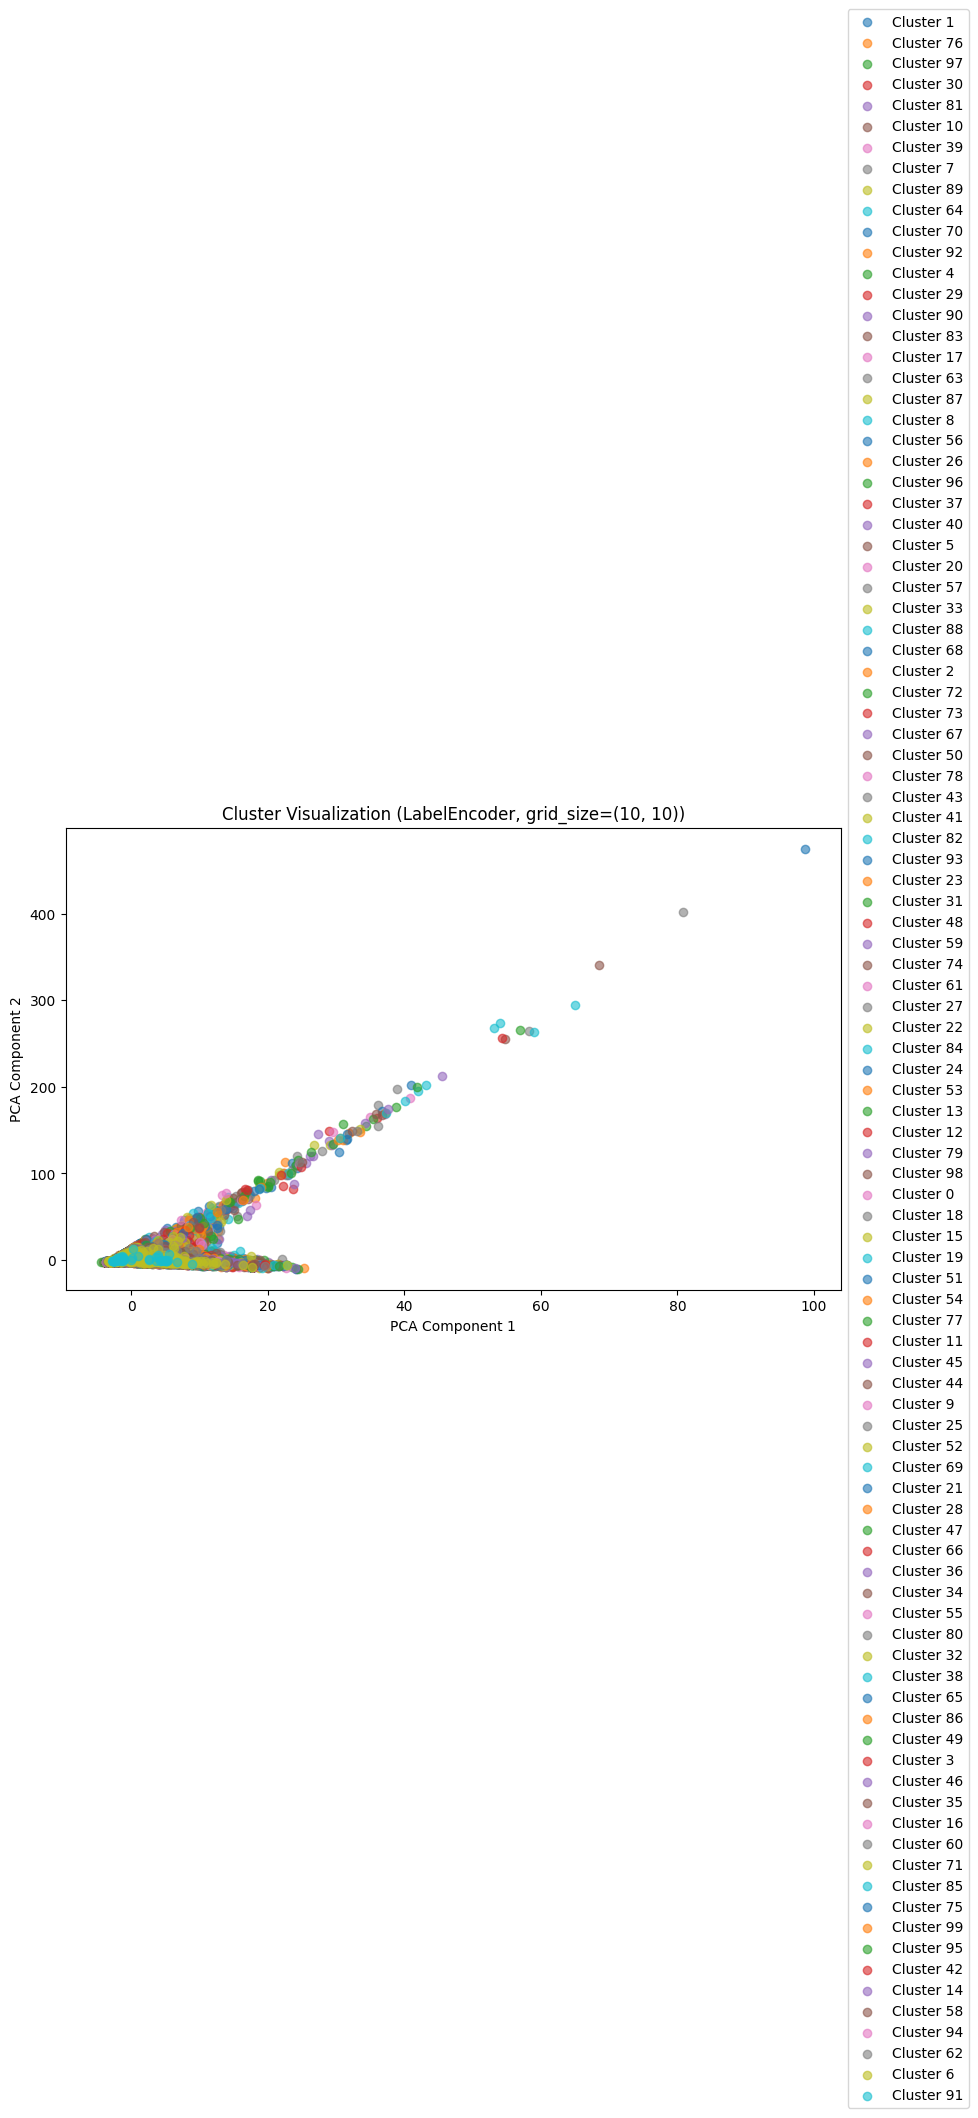

starting metrics
ending metrics


<ipython-input-23-4bf63dd07820>:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


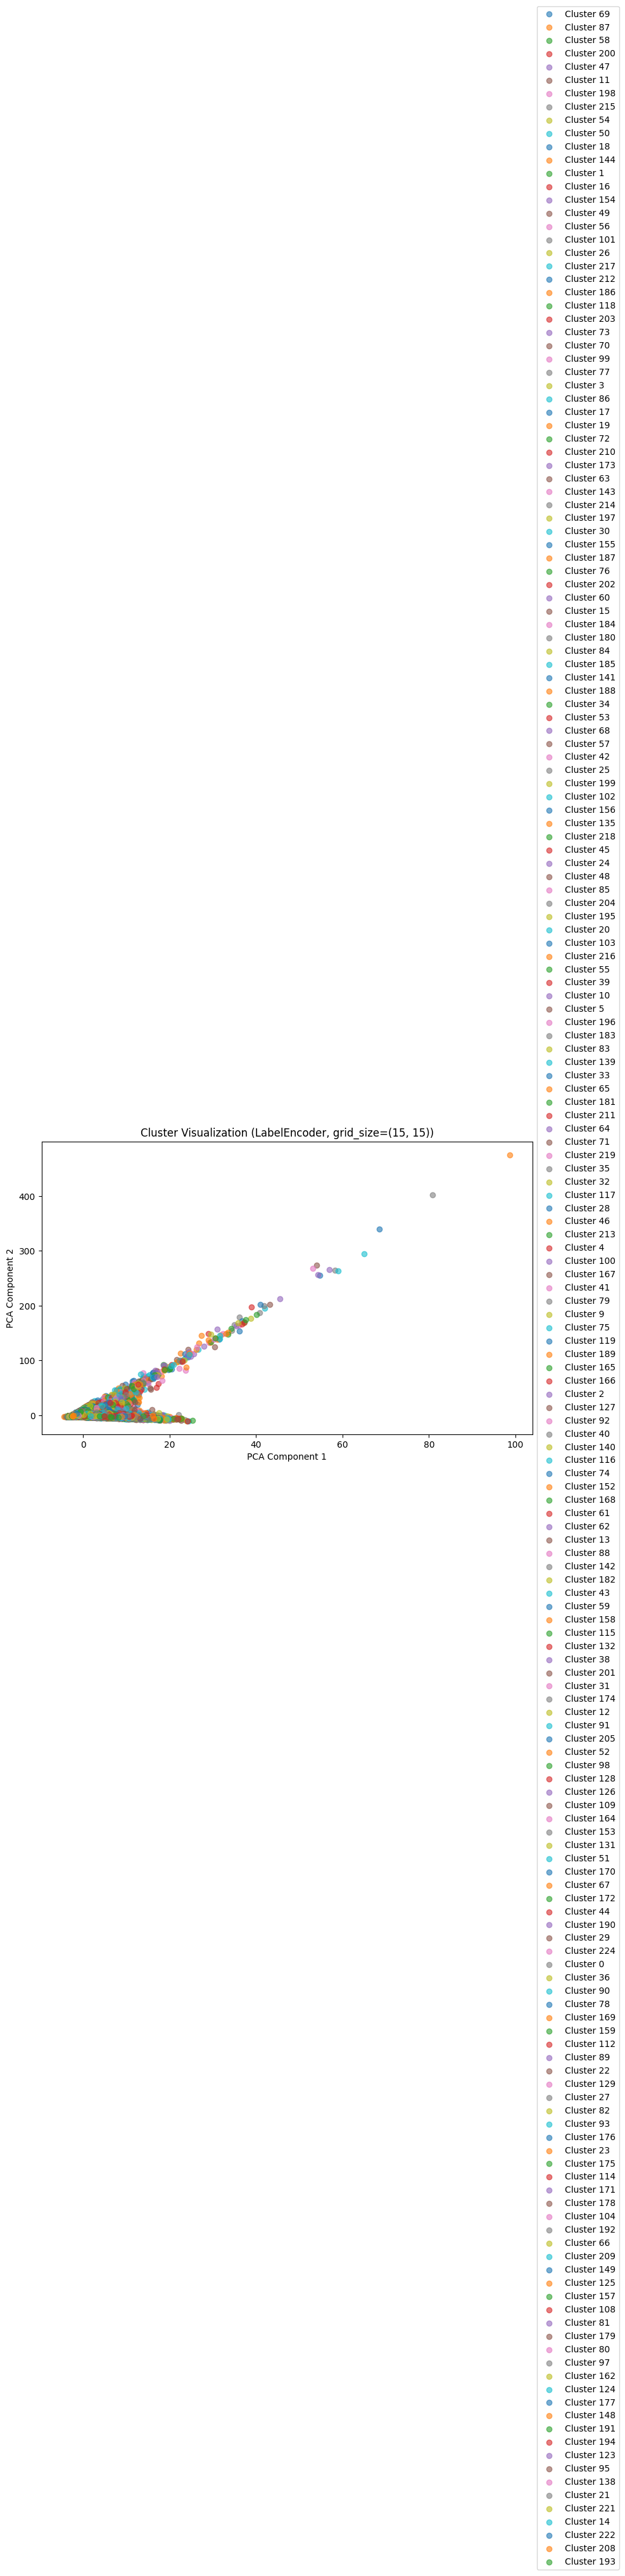

Optimal number of clusters: 100


In [ ]:
######################################################################################################################
# LabelEncoder with SOFM
# Train the Self-Organizing Feature Map (SOM) on the label-encoded, PCA-reduced data
# - Returns the cluster labels assigned by the SOM and the trained SOM object

# Evaluate the clustering results using metrics like ARI, NMI, FMI, etc.
# - The evaluation uses true labels mapped from Source.IP and returns a dictionary of scores
######################################################################################################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for grid_size in grid_sizes:
    logging.info(f"Running SOFM (LabelEncoder): Grid Size={grid_size}")

    # Send data to GPU
    data_gpu = torch.tensor(data_scaled_label_reduced, dtype=torch.float32).to(device)

    # Run GPU-compatible SOM
    X_train, X_val, X_test, train_labels, val_labels, test_labels, som_label = perform_sofm(data_gpu, grid_size)

    # ✅ Convert outputs to NumPy if they're tensors
    X_train = to_numpy(X_train)
    X_val = to_numpy(X_val)
    X_test = to_numpy(X_test)
    train_labels = to_numpy(train_labels)
    val_labels = to_numpy(val_labels)
    test_labels = to_numpy(test_labels)
    som_label = to_numpy(som_label)

    # Create generic feature names
    num_cols = X_train.shape[1]
    col_names = [f'Feature_{i}' for i in range(num_cols)]

    # Create DataFrame for clustering
    clustered_data_label = pd.DataFrame(X_train, columns=col_names)
    clustered_data_label['Source.IP'] = df_0.loc[df_reduced.index[:len(X_train)], 'Source.IP'].values
    clustered_data_label['Cluster'] = train_labels

    # Evaluate and plot
    metrics_label = evaluate_clustering(clustered_data_label, "LabelEncoder", grid_size, som=som_label, data_scaled=data_scaled_label_reduced)
    results_table.append(metrics_label)
    plot_clusters(data_scaled_label_reduced, clustered_data_label, train_labels, grid_size, "LabelEncoder")

# Final analysis
results_df = pd.DataFrame(results_table)
optimal_n_clusters = find_optimal_clusters(results_df)
print(f"Optimal number of clusters: {optimal_n_clusters}")

In [ ]:
######################################################################################################################
# Write Results Table to CSV file
######################################################################################################################

results_df.to_csv('results_label_table.csv', index=False)
results_df = pd.DataFrame(results_table)

starting metrics
ending metrics


<ipython-input-23-4bf63dd07820>:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


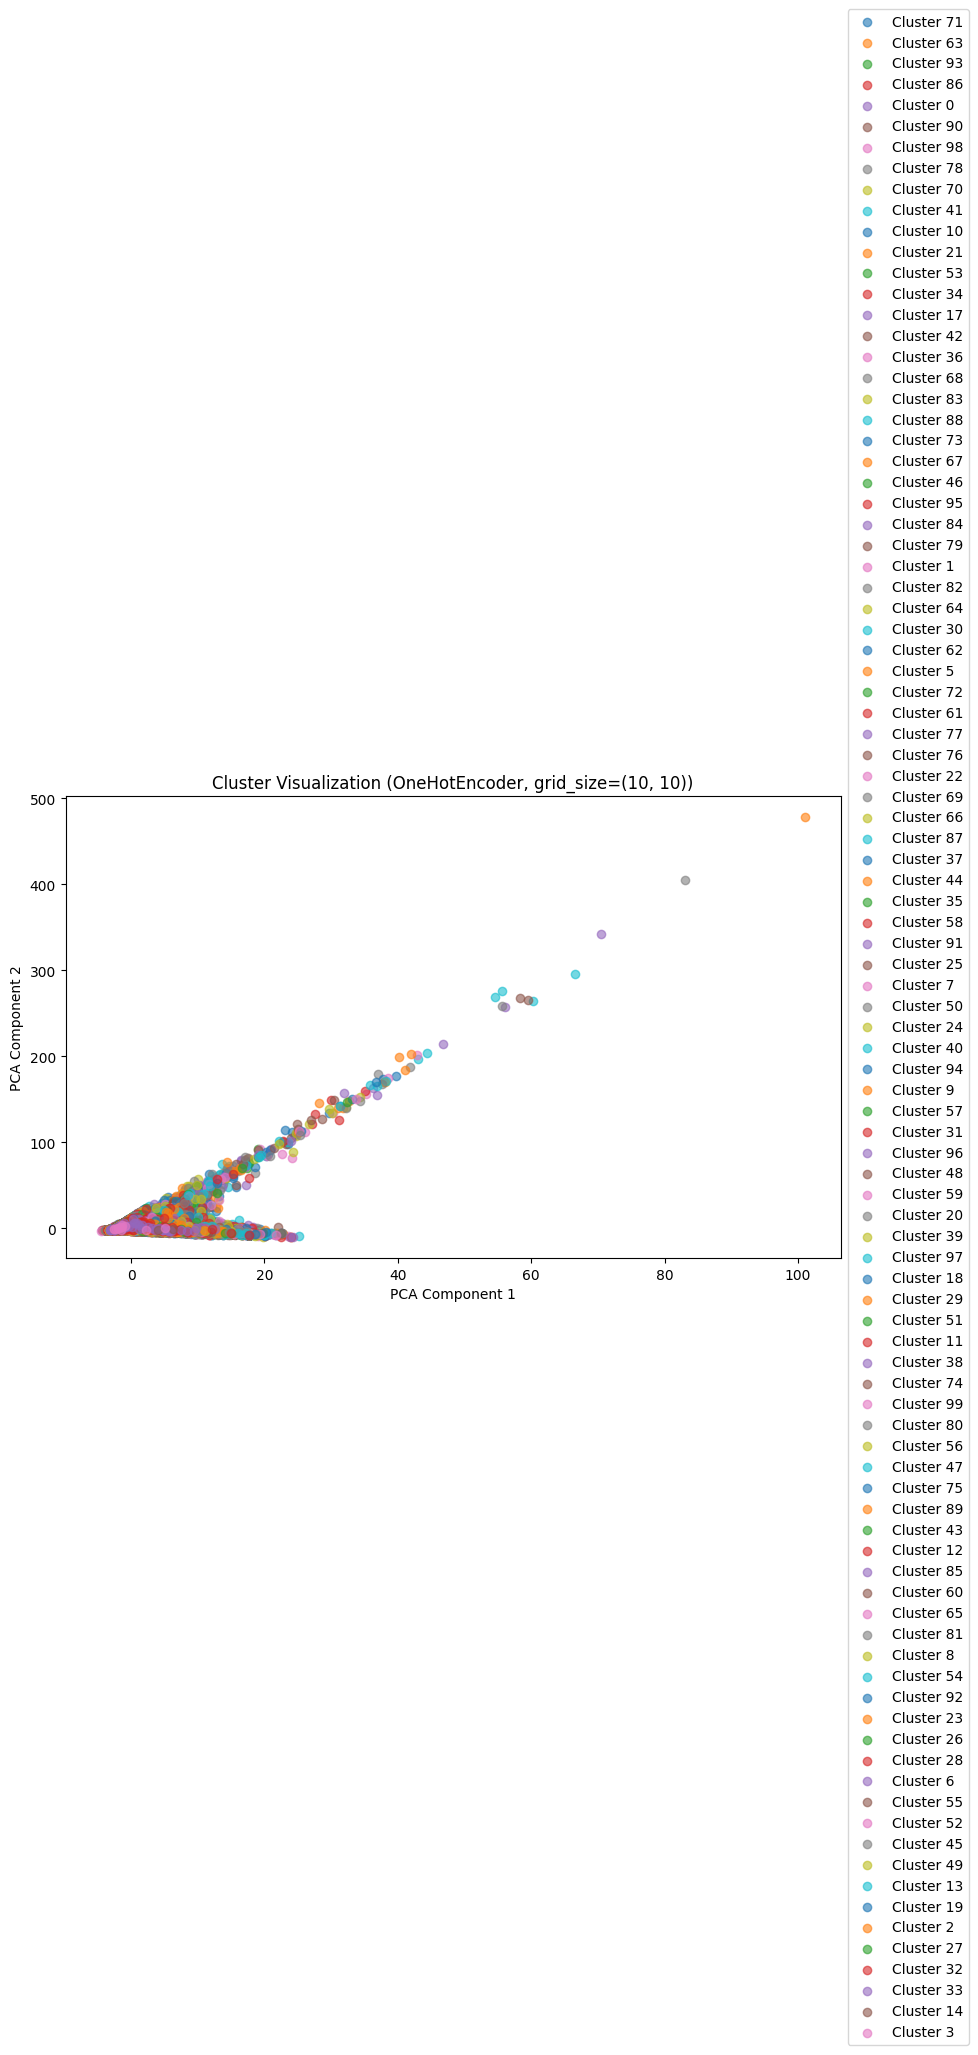

starting metrics
ending metrics


<ipython-input-23-4bf63dd07820>:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


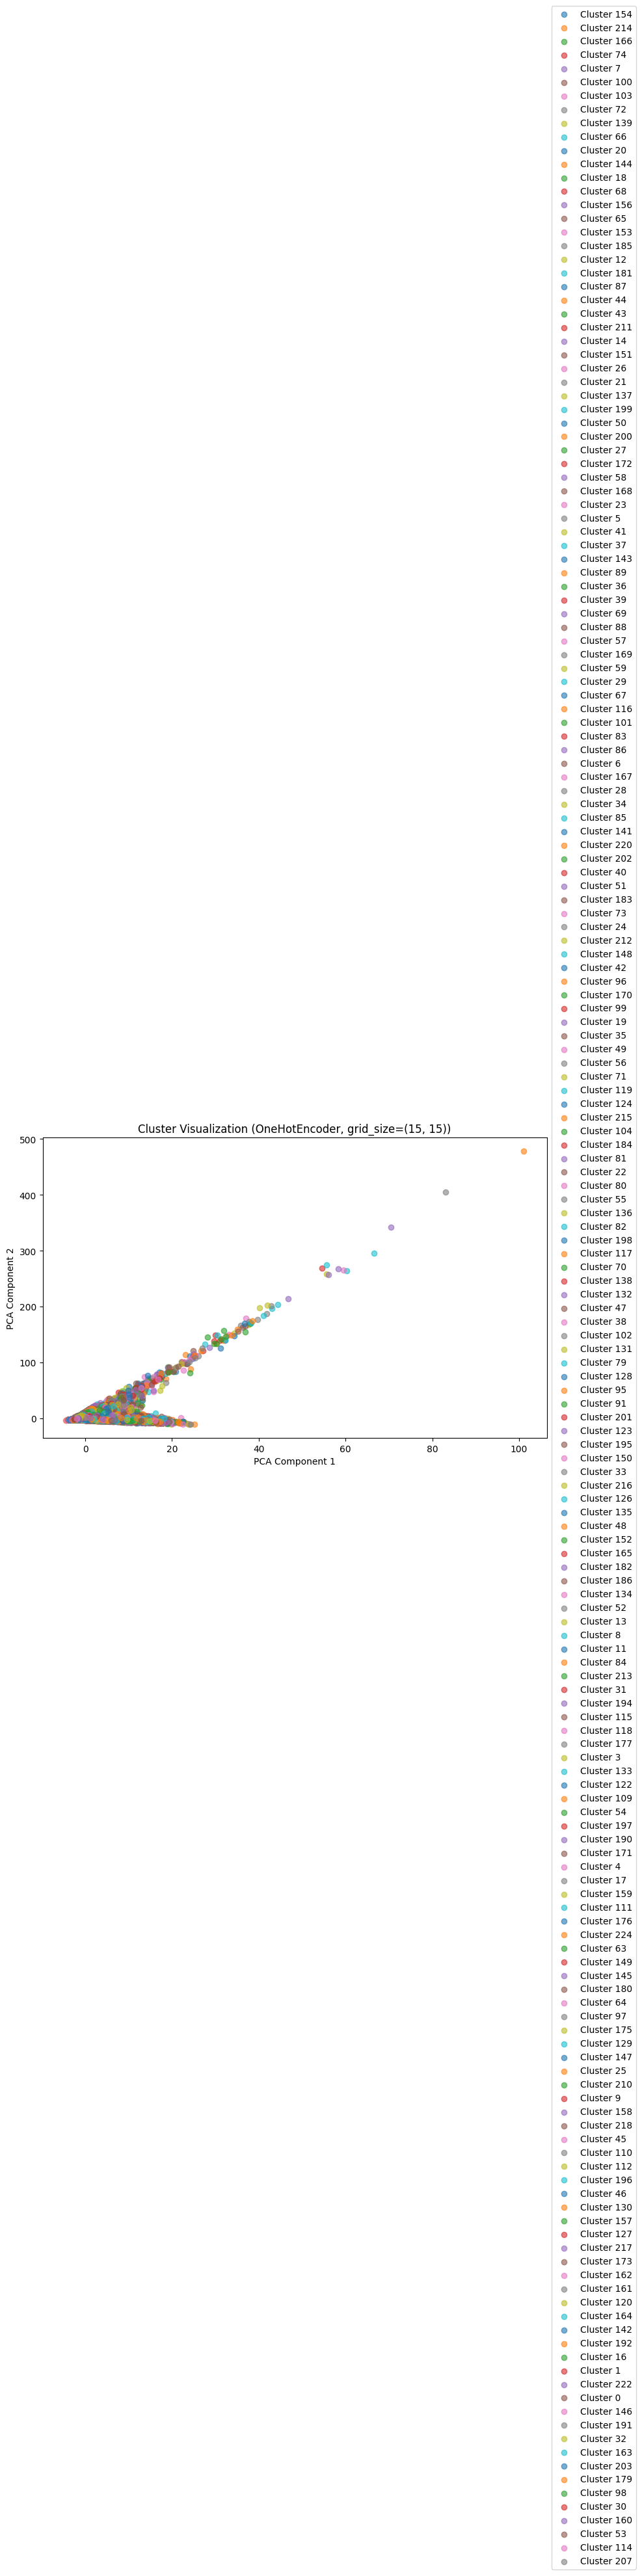

Optimal number of clusters: 100


In [ ]:
######################################################################################################################
# OneHotEncoder with SOFM
# Loop through each SOM grid size to evaluate clustering using OneHot encoded features
# Log the current grid size being used in the experiment for tracking
# Train a Self-Organizing Feature Map (SOM) on the PCA-reduced one-hot encoded data
# - Returns predicted labels (clusters) and the trained SOM object
# Create a copy of the original data and attach the predicted cluster labels
# Evaluate clustering performance using true labels and store metrics
# - Metrics include ARI, NMI, FMI, Homogeneity, Completeness, and V-measure
# Visualize the clustering results in 2D using PCA-reduced data
# - Includes color-coded clusters and a title indicating encoding type and grid size
######################################################################################################################

for grid_size in grid_sizes:
    logging.info(f"Running SOFM (OneHotEncoder): Grid Size={grid_size}")

    # Move input data to GPU
    data_gpu = torch.tensor(data_scaled_one_hot_reduced, dtype=torch.float32).to(device)

    # Perform SOM (GPU-compatible)
    X_train, X_val, X_test, train_labels, val_labels, test_labels, som_one_hot = perform_sofm(data_gpu, grid_size)

    # Convert tensors to NumPy arrays if needed
    X_train = to_numpy(X_train)
    X_val = to_numpy(X_val)
    X_test = to_numpy(X_test)
    train_labels = to_numpy(train_labels)
    val_labels = to_numpy(val_labels)
    test_labels = to_numpy(test_labels)
    som_one_hot = to_numpy(som_one_hot)  # Only if you use it in pandas/sklearn/etc.

    # Create DataFrame for training data with cluster assignments
    num_cols = X_train.shape[1]
    col_names = [f'Feature_{i}' for i in range(num_cols)]

    clustered_data_one_hot = pd.DataFrame(X_train, columns=col_names)
    clustered_data_one_hot['Source.IP'] = df_0.loc[df_reduced.index[:len(X_train)], 'Source.IP'].values
    clustered_data_one_hot['Cluster'] = train_labels

    # Evaluate clustering
    metrics_one_hot = evaluate_clustering(
        clustered_data_one_hot,
        "OneHotEncoder",
        grid_size,
        som=som_one_hot,
        data_scaled=data_scaled_one_hot_reduced
    )
    results_table.append(metrics_one_hot)

    # Visualize clusters
    plot_clusters(data_scaled_one_hot_reduced, clustered_data_one_hot, train_labels, grid_size, "OneHotEncoder")

# Final cluster evaluation
results_df = pd.DataFrame(results_table)
optimal_n_clusters = find_optimal_clusters(results_df)
print(f"Optimal number of clusters: {optimal_n_clusters}")

In [ ]:
######################################################################################################################
# Write Results Table to CSV file
######################################################################################################################

#results_df.to_csv('results_full_table.csv', index=False)
results_df = pd.DataFrame(results_table)

results_df.columns

Index(['Encoding Type', 'n_clusters', 'Silhouette Score',
       'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'Inertia',
       'Adjusted Rand Index (ARI)', 'Normalized Mutual Information (NMI)',
       'Fowlkes-Mallows Index (FMI)', 'Homogeneity', 'Completeness',
       'V-measure', 'True Positives (TP)', 'True Negatives (TN)',
       'False Positives (FP)', 'False Negatives (FN)'],
      dtype='object')

In [ ]:
######################################################################################################################
# Print Results Table
######################################################################################################################

results_df = pd.DataFrame(results_table)
print("\nClustering Results:")
print(results_df)


Clustering Results:
   Encoding Type  n_clusters  Silhouette Score  Davies-Bouldin Index  \
0   LabelEncoder          99         -0.098593             94.937786   
1   LabelEncoder         167         -0.498048             65.800226   
2  OneHotEncoder          95         -0.147516             92.433004   
3  OneHotEncoder         162         -0.511999             60.631301   

   Calinski-Harabasz Index   Inertia  Adjusted Rand Index (ARI)  \
0                 1.002805  3.079924                   0.000006   
1                 0.945579  2.993594                   0.000046   
2                 0.987486  3.345001                  -0.000019   
3                 0.924269  3.317826                   0.000062   

   Normalized Mutual Information (NMI)  Fowlkes-Mallows Index (FMI)  \
0                             0.026720                     0.029174   
1                             0.030812                     0.026391   
2                             0.025390                     0.029135  

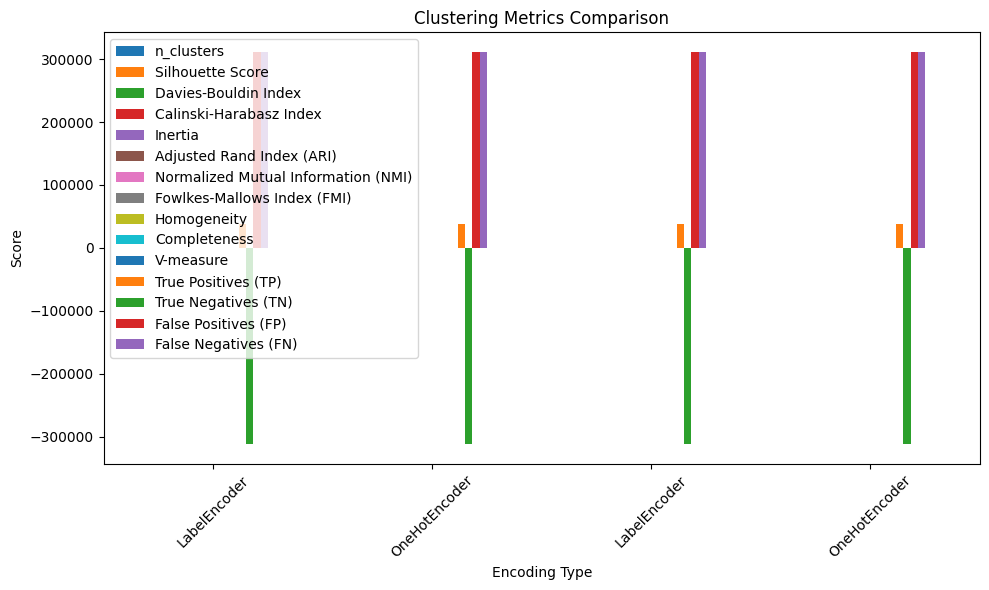

In [ ]:
######################################################################################################################
# Display Visualizations
######################################################################################################################

# Plot evaluation metrics
plot_metrics(results_df)

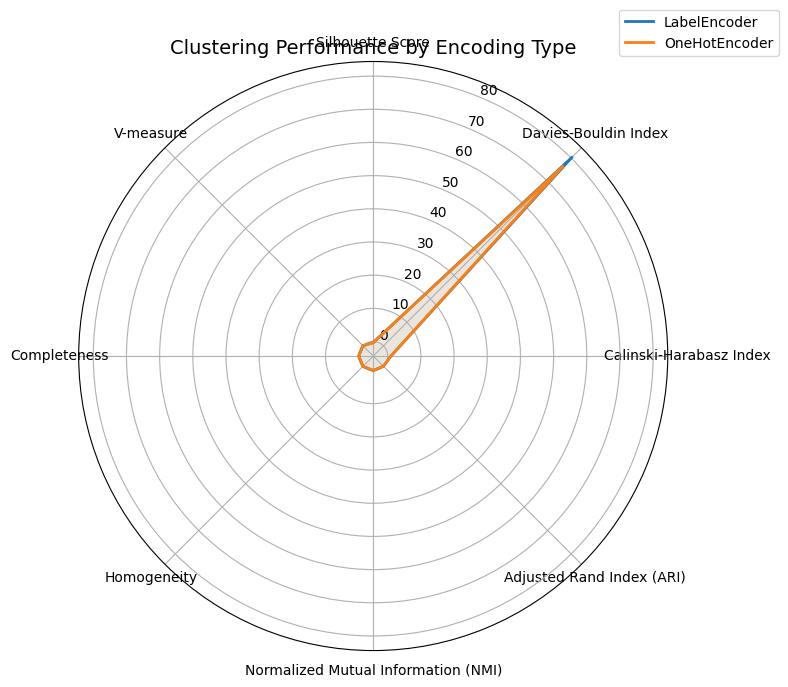

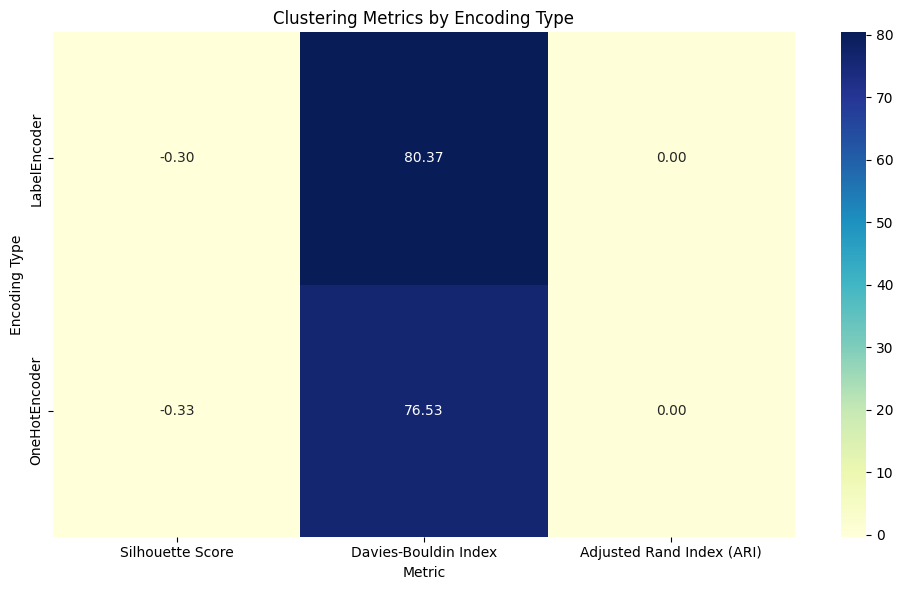

In [ ]:
######################################################################################################################
# Visualization of Radar graph and Heatmap

# Radar graph
# Call the radar chart plotting function to visually compare clustering performance
# across multiple encoding types and evaluation metrics.
# This chart is especially useful for seeing how each encoding performs relative to others
# across several dimensions like Silhouette Score, ARI, Homogeneity, etc.
# Heatmap
# Call the heatmap plotting function to display a grid of average metric scores
# for each encoding type. This provides a quick, at-a-glance comparison of performance
# using color intensity and numerical values.
# Ideal for identifying strong or weak encodings for specific metrics.
######################################################################################################################

plot_radar_metrics(results_df)
plot_heatmap(results_df)

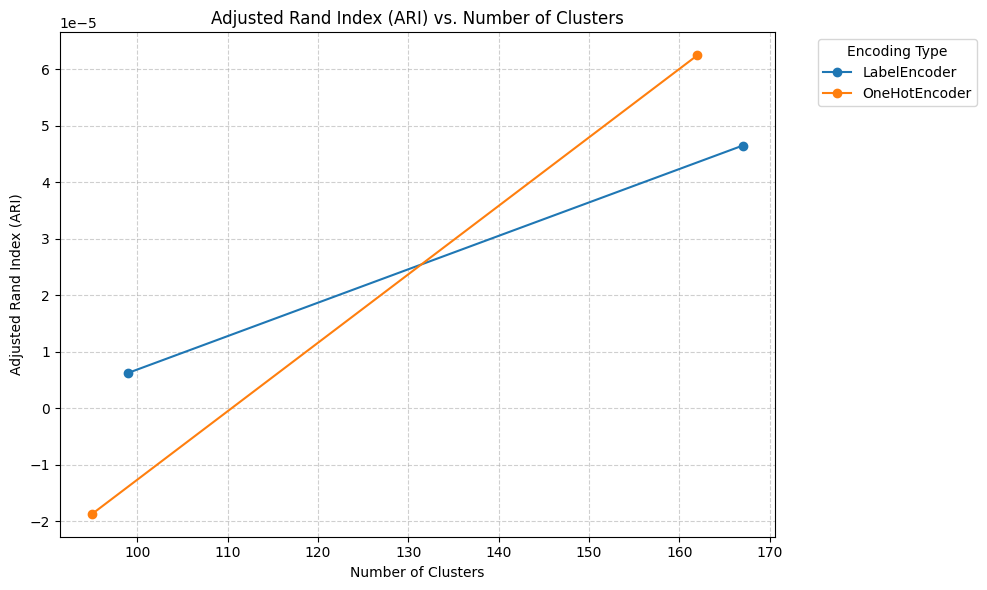

In [ ]:
######################################################################################################################
# Call visualization of Metrics over Clusters Function
# Plot how evaluation metric changes as the number of clusters increases, for each encoding type.
######################################################################################################################

plot_metric_over_clusters(results_df, metric='Adjusted Rand Index (ARI)')

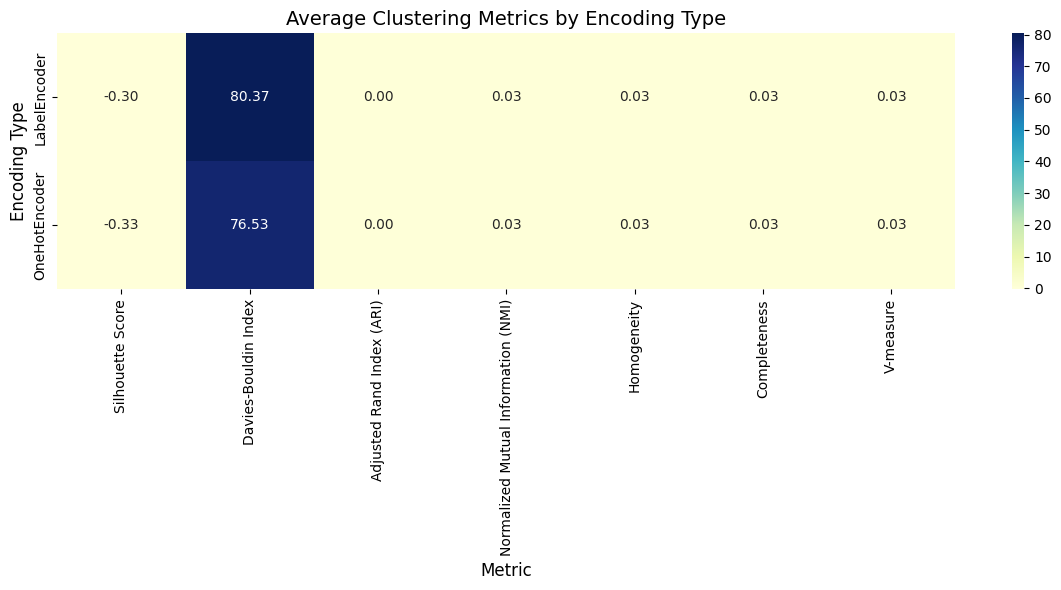

In [ ]:
######################################################################################################################
# Visualization of Encoder Heatmap
# Plot the heatmap using seaborn
# - annot=True: show metric values in the heatmap cells
# - fmt=".2f": format numbers to 2 decimal places
# - cmap="YlGnBu": color map from yellow to green to blue
# - cbar=True: display color bar legend
######################################################################################################################

plot_encoder_metric_heatmap(results_df)

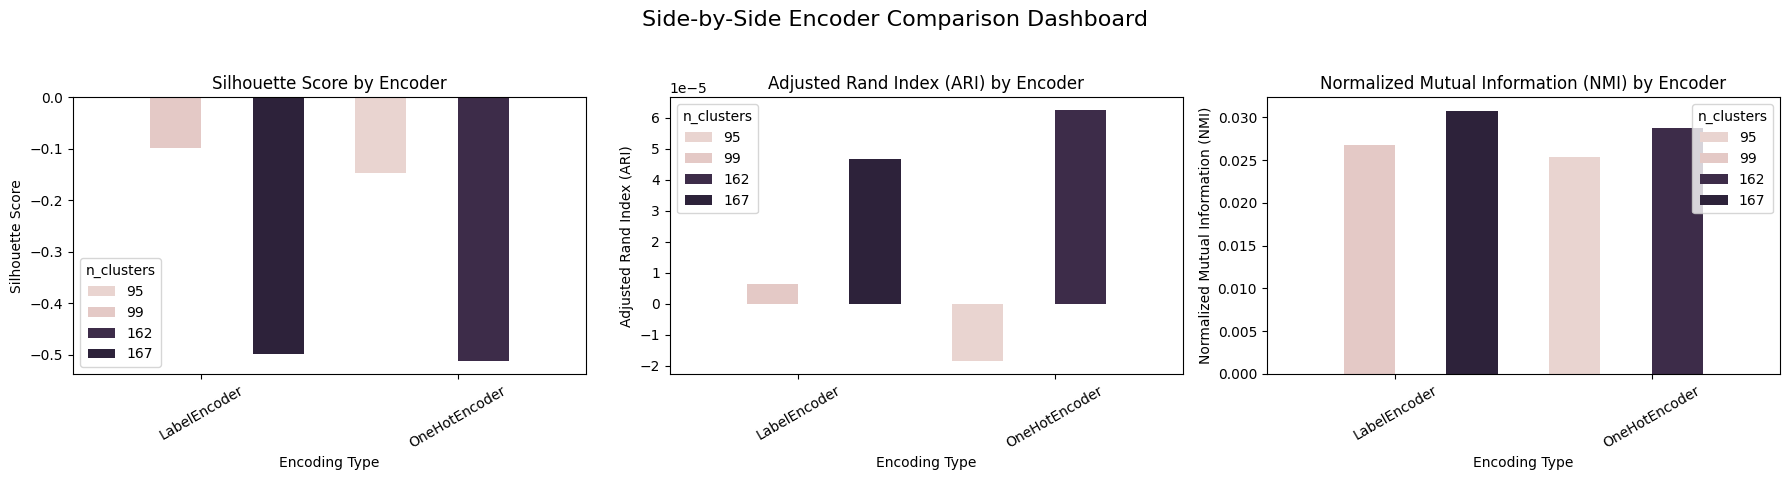

In [ ]:
######################################################################################################################
# Visualization of Encoder Comparison Dashboard
# Use seaborn to plot a bar chart for the current metric
# - x: Encoding Type
# - y: Metric value
# - hue: n_clusters to show performance variation by cluster count
######################################################################################################################

plot_encoder_comparison_dashboard(results_df)

In [ ]:
######################################################################################################################
# Visualization of Leaderboard Table
# Call visualizaton of leaderboard function
# Create metrics list
# Disply Leaderboaed Table
######################################################################################################################

metrics = [
    'Silhouette Score',
    'Davies-Bouldin Index',
    'Adjusted Rand Index (ARI)',
    'Normalized Mutual Information (NMI)',
    'Homogeneity',
    'Completeness',
    'V-measure'
]

leaderboard_df = results_df.groupby('Encoding Type')[metrics].mean()
print("Leaderboard (average across n_clusters):")
print(leaderboard_df.round(3))

Leaderboard (average across n_clusters):
               Silhouette Score  Davies-Bouldin Index  \
Encoding Type                                           
LabelEncoder             -0.298                80.369   
OneHotEncoder            -0.330                76.532   

               Adjusted Rand Index (ARI)  Normalized Mutual Information (NMI)  \
Encoding Type                                                                   
LabelEncoder                         0.0                                0.029   
OneHotEncoder                        0.0                                0.027   

               Homogeneity  Completeness  V-measure  
Encoding Type                                        
LabelEncoder         0.028         0.029      0.029  
OneHotEncoder        0.026         0.028      0.027  


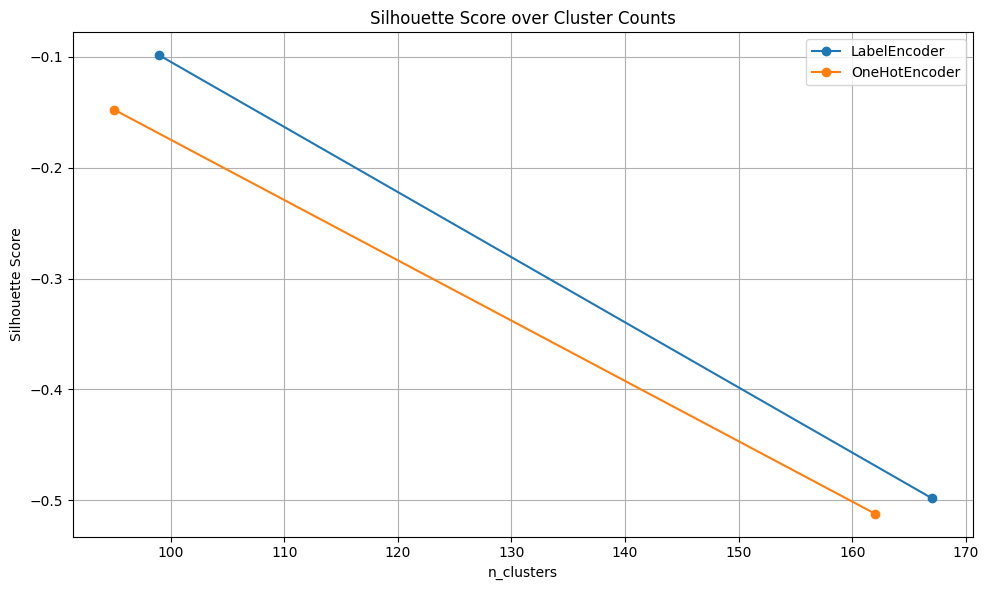

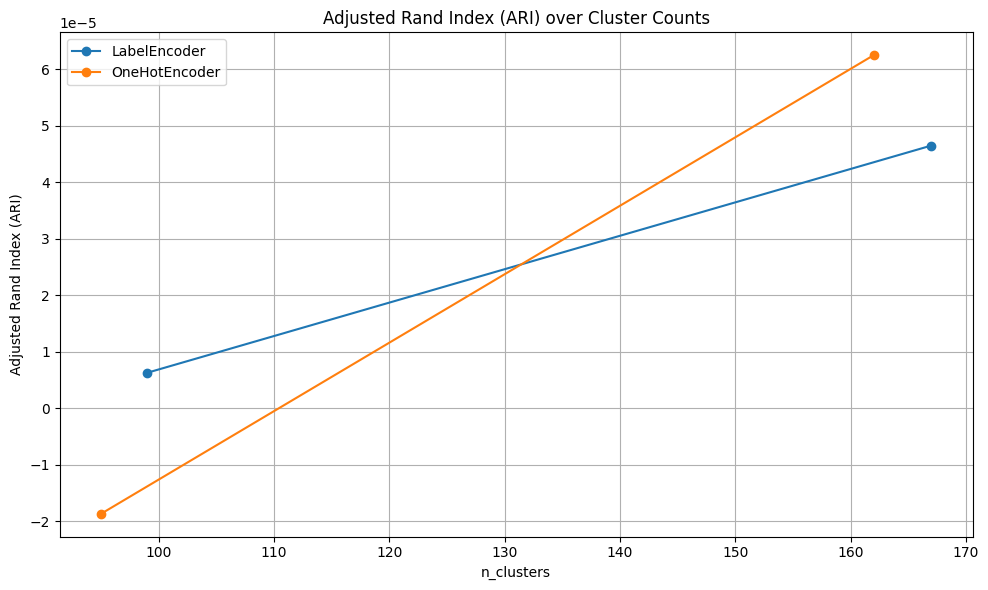

In [ ]:
######################################################################################################################
# Visualization of Metric Trends
# Plot the metric values against the number of clusters
# Use markers to emphasize each point and label the line with the encoding name
######################################################################################################################

plot_metric_trends(results_df, metric='Silhouette Score')
plot_metric_trends(results_df, metric='Adjusted Rand Index (ARI)')

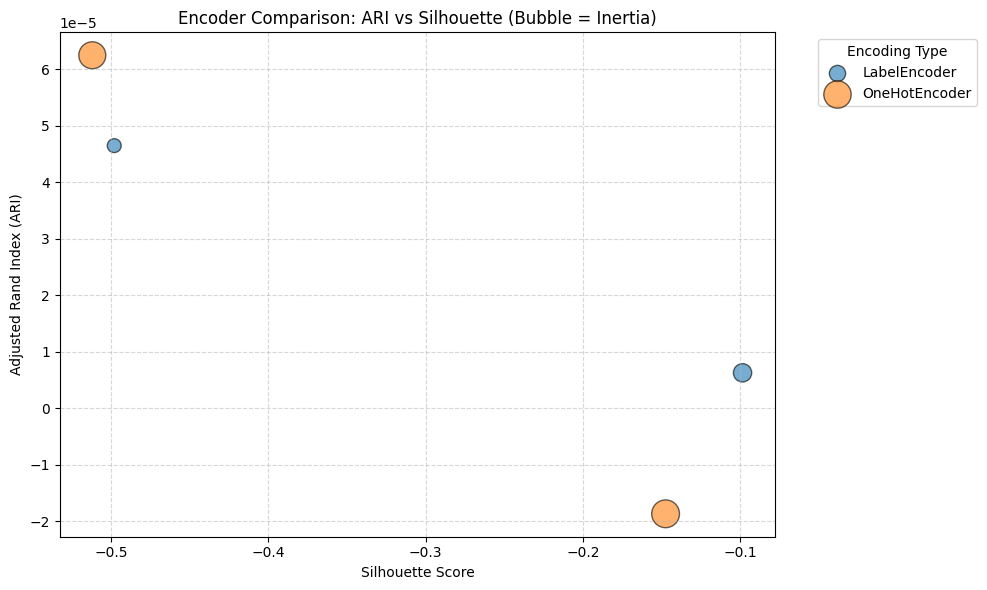

In [ ]:
######################################################################################################################
# Visualization of Bubble Chart
#    Creates a bubble chart with:
#        X-axis = Silhouette Score
#        Y-axis = Adjusted Rand Index
#        Bubble size = normalized Inertia
######################################################################################################################

plot_bubble_chart(results_df)

<ipython-input-35-7142594651ef>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rank_scores.values, y=rank_scores.index, palette="coolwarm")


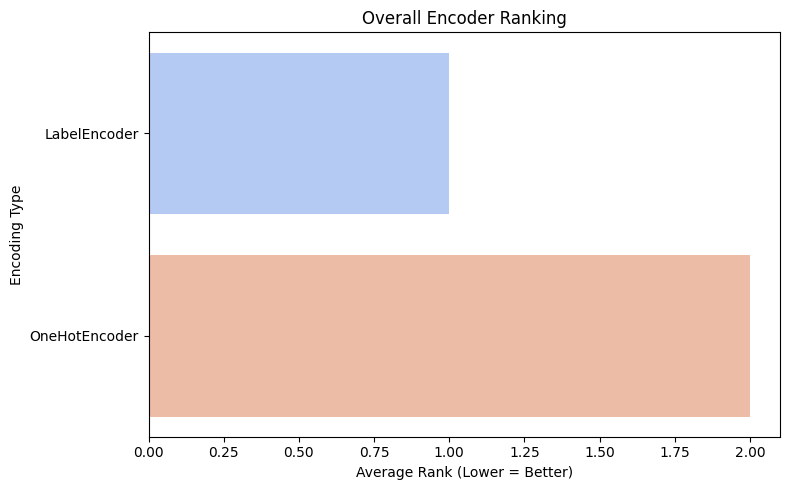

In [ ]:
######################################################################################################################
# Visualization of Encoder Ranking
# Plot a horizontal bar chart of average ranks
# Lower values (top of the chart) represent better-performing encodings
######################################################################################################################

plot_encoder_ranking(results_df, metrics)

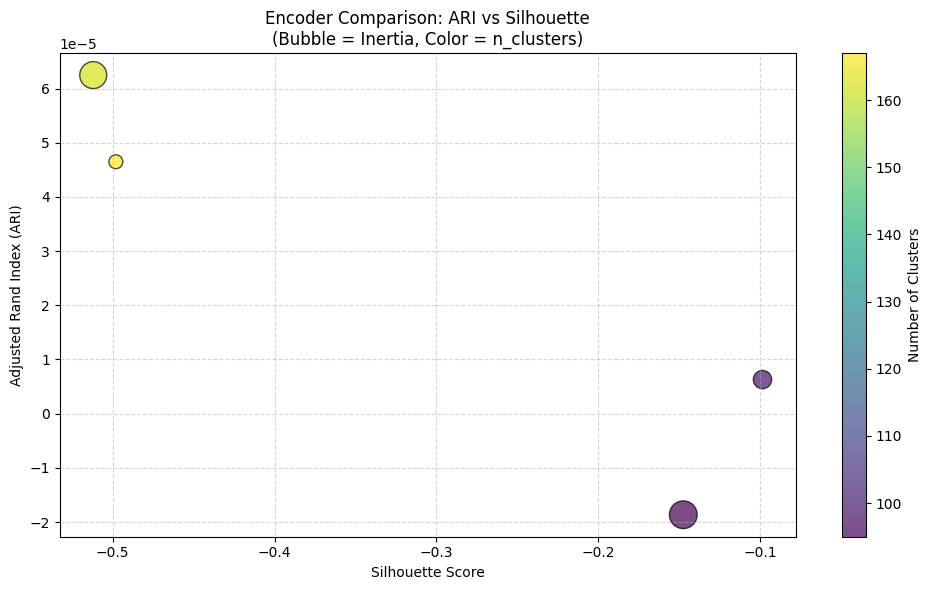

In [ ]:
######################################################################################################################
# Visualization of Bubble Chart with Cluster Gradient
#    Bubble chart:
#    - X-axis: Silhouette Score
#    - Y-axis: Adjusted Rand Index (ARI)
#    - Bubble size: normalized Inertia
#    - Color: gradient based on n_clusters

######################################################################################################################

plot_bubble_chart_with_cluster_gradient(results_df)